In [5]:
%matplotlib inline
import mglearn
import matplotlib.pyplot as plt

## Ensembles of Decision Trees

These are usually used in place of a single decision tree.  __Ensemble__ methods combine multiple ML methods for a more powerful model.  Thre are many ensamble models but two of the most effective on wide ranges of datasets for botj classification and regression are random forests and gradient boosted decision trees.  Both of these methods use decision trees as their building blocks.

### Random forests 

These are one way to address the problem of overfitting from decision trees.  This method uses a collection of decision trees, each slightly different.  If each tree id different and overfits in different ways we can average the results together and get a reduction to the overfitting of a single tree.

To deploy this method we need to make many trees, where each tree is different but still produces an acceptable result.  The random comes from how the trees are built randomly to ensure they are different.  The randomness specifically comes from the choice of the data points used to build the trees and by testing and splitting on different features.

##### Building our random forest

First we need to decide the number of tree to build (`n_estimators` in `RandomForestRegressor` or `RandomForestClassifier`.  The algorithm builds the tree independently from each other and will make different random choices to build each tree.  To build a tree we need to take a __bootstrap sample__ of our data, or from out `n_samples` data points we draw randomly with replacement.  This ends up creating a dataset that is the same size as the original but with some points missing (~1/3) or repeated and also leads to a slightly different dataset for each tree made..  A decision tree is then built with this dataset using a slightly moified algorithm. For each node the algorithm randomly selects a subset of the features, and it looks for the best possible test involving one of these features (controlled by `max_features` parameter).  This is repeated for each node.  The combination of bootstrap sampling and splitting on different feature subsets ensures all different trees in the forest. 

Setting `max_features` is critical. `max_features = n_features` lets the tree look at all features for a split (and therefore no randomness in feature selection). `max_features = 1` causes no choice at all and we can just pick the best threshold to split on.  So a high `max_features` causes more similar trees that all easily fit the data while a low `max_features` causes the trees to be very different and possibly very deep to fit the data.

To make a prediction the algorithm first mkaes a prediction with every tree. For a regression the results are averaged together for the final prediction.  For classification, "soft voting" is used, meaning a "soft" prediction is made by each algorithm giving a probability for each possible label.  Tehy are then averaged togwther and the label with the highest average probability is the predicted label.

##### Analyzing random forests

We'll use the `two_moons` set.  When the trees are built, they are stored in the `estimator_` attribute.  The decision boundaries are visualized below.

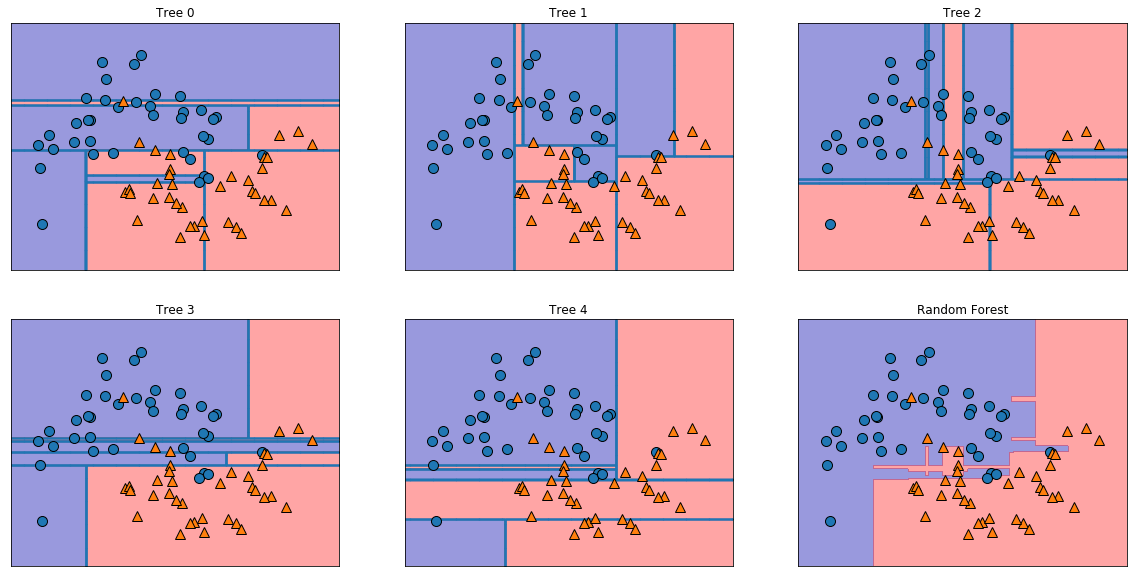

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
 random_state=42)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

As we can see the decision boundaries are all quite different and each has some mistakes because of the bootstrap sampling.  The random forest overfits less than any of the individual trees and has a more intuitive decision boundary.

In practice we would use many more trees (hundreds or thousands of trees) which cause even smoother boundaries.

Now applying the method to the real dataset on breast cancer with a 100 tree forest:

In [11]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


Right away we get 97% (better than linear models and individual decision trees) without tuning any parameters.  We could tune them but often the defaults work quite well. Random forests also provide feature importances which are usually more reliable than from a single tree.

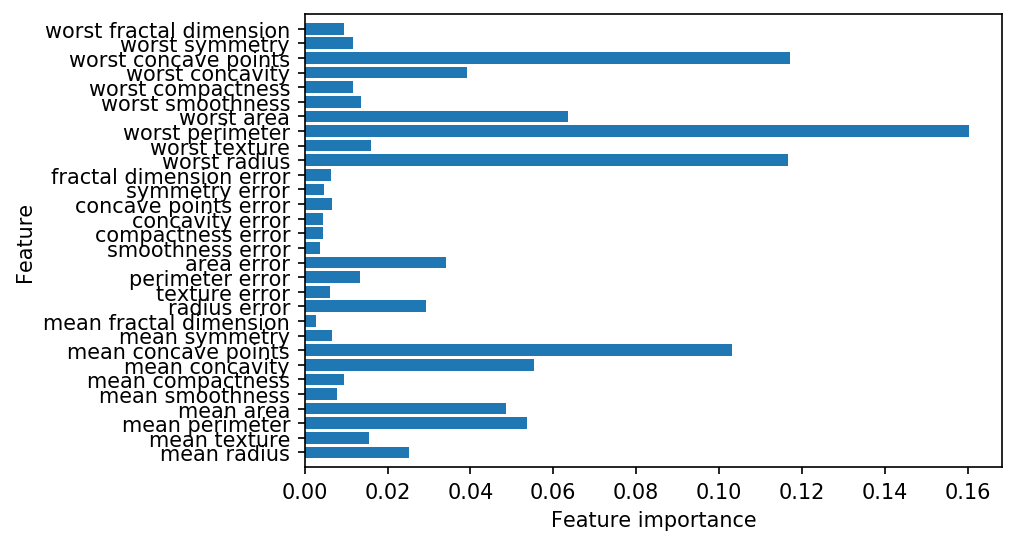

In [12]:
def plot_feature_importances_cancer(model):
    plt.figure(dpi=150)
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(forest)

We see the forest gived more features nonzero importances than a single tree.  The randomness of the algorithm forces consideration of other options therefore capturing a broader look at the data.

_Strengths, weaknesses, and parameters_

Currently some of the most widely used ML methods today since they work well without much heavy tuning and don't require scaling.  They have all the benefits of decision trees while fixing some of their downsides.

One reason to still use a single tree is fro compact representation of decision making process.  Random forest trees are usually deeper because of feature subset use so a single tree visualizes better.

Building forests on large datasets can be time consuming but it can be parallelized across multiple cores with the `n_jobs` parameter (casues a linear speed up). `njobs=-1` will use all cores available.

Since random forests are random (duh) setting `random_state` to different values can drastically change the outcome.  For reproducable results you need to set it.

Random forests don't tend to perform well on sparse high dimensional data (use a linear model instead).  They do work well on large datasets though but with high memory usage and slower training.  If these are concerns maybe use a linear model.

Important paramaters: `n_estimators` (larger always better but with dimimishing return - "build as many as you have time/memory for"), `max_features` (good rule of thumb to use the default `sqrt(n_features)`), and `max_depth`/`max_leaf_nodes` if you want pre-pruning.  Tuning `max_depth` and `max_leaf_nodes` can sometimes improve performance.

##### Gradient boosted regression trees (gradient boosting machines)

Another ensemble method that combines decision trees.  Despite the regression name it can be used for regressions and classification.Unlike the random forest, these trees are built in a serial manner where each tree tries to correct the mistakes of the previous tree.  By default there is no randomization but instead they use strong pre-pruning.  In general trees are shallow (1 to 5 in depth) making them smaller in memory and faster to predict.

The main idea is to combine simple models like shallow trees (__weak learners__).  Each tree can only predict well on one part of the data so adding more trees improves performance.

These types of models often win machine learning contests and are widely used in industry.  They are more sensitive to parameter settings but well tuned models generally have inmproved accurcy over random forests.

A major paramter is the `learning_rate` which controls how aggressively the model tries to make corrections on the last iteration (higher means more corrections).  Like the random forest we can add more trees by setting `n_estimators`.  Both increase model complexity as they get larger.

Here we test on the breast cancer data (defaults of 100 trees, max depth off 3, learning rate of 0.1):

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}\n".format(gbrt.score(X_test, y_test)))

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}\n".format(gbrt.score(X_test, y_test)))

gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965

Accuracy on training set: 0.991
Accuracy on test set: 0.972

Accuracy on training set: 0.988
Accuracy on test set: 0.965


As we can see we probably over fit with the defaults since the training accuracy is 100%.  We can try to fix this by reducing the `max_depth` or lowering the `learning_rate`.  In this case reducing `max_depth` gives significant improvement.

Like the other decision tree models we can visualize the feature importances (even with depths of 1, on 100 trees it's impractical to inspect them all individually).

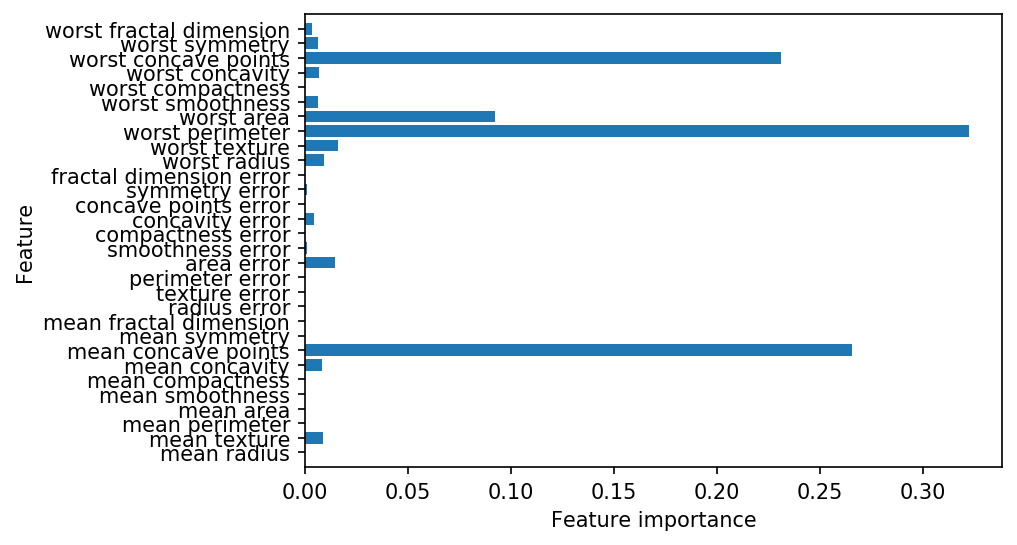

In [14]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
plot_feature_importances_cancer(gbrt)

So we have similar plot to the random forest but some of the features are completely ignored. Random forests and gradient boosting performs well on similar types of datasets. A common method is to first try implementing a random forest and if it works weel but prediction time needs to be reduced or you need to squeeze out every last pit of accuracy you should switch to a gradient boosting method.

When applying gradient boosting to a largescale problem switching to the `xgboost` package can be beneficial (faster an sometime easier to use than `scikit-learn` implementation.